In [13]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
np.random.seed(322)
fraud_df = pd.read_csv('/content/drive/MyDrive/creditcard_2023.csv')

In [19]:
#x = fraud_df.drop(['id','Class'],axis=1).values
y = fraud_df.Class.values
x = fraud_df.iloc[:,1:29].values
#x = fraud_df.iloc[:,12:14].values
z = fraud_df.iloc[:,12:14].values
print(z)

[[ 0.2934381  -0.94138613]
 [ 1.56424577  0.57407401]
 [ 0.65920066  0.80517319]
 ...
 [-0.46184889 -0.60609963]
 [ 0.33521507  0.46417742]
 [-1.1530113   0.48919666]]


In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x,y,z,test_size=0.3)
#x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x,y,z,test_size=0.9999)

In [21]:
from sklearn.preprocessing import StandardScaler
x_train_std = StandardScaler().fit_transform(x_train)
x_test_std = StandardScaler().fit_transform(x_test)
z_train_std = StandardScaler().fit_transform(z_train)
z_test_std = StandardScaler().fit_transform(z_test)

In [22]:
from sklearn.decomposition import PCA
n_components = 2
pca = PCA(n_components=n_components)
x_pca = pca.fit_transform(x)
x_train_pca = pca.fit_transform(x_train_std)
x_test_pca = pca.fit_transform(x_test_std)
print(x_train_pca)

[[ 2.56541947 -0.70704287]
 [ 2.29648696  0.30837241]
 [-6.79334283  0.96856382]
 ...
 [ 2.32381068  0.3184379 ]
 [-6.76866908  1.44133597]
 [ 2.34047756 -0.1457627 ]]


training Adaline-linear


<ipython-input-23-ac5fc2ebcd0e>:21: RuntimeWarning: overflow encountered in square
  cost = (errors**2).sum() / 2.0
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


training Adaline-sigmoid


<ipython-input-23-ac5fc2ebcd0e>:32: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X))


training Adaline-tanh


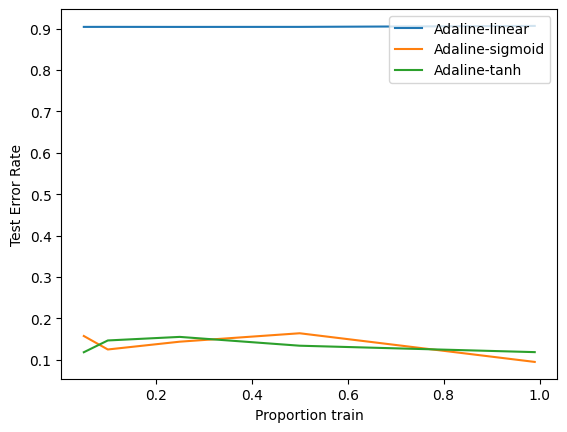

In [23]:
heldout = [0.95, 0.90, 0.75, 0.50, 0.01]
rounds = 10

# Реализация Adaline с различными функциями активации
class Adaline(BaseEstimator, ClassifierMixin):
    def __init__(self, eta=0.01, n_iter=50, activation='linear'):
        self.eta = eta
        self.n_iter = n_iter
        self.activation = activation

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for _ in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activate(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activate(self, X):
        if self.activation == 'linear':
            return X
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-X))
        elif self.activation == 'tanh':
            return np.tanh(X)
        else:
            raise ValueError("Unknown activation function: {}".format(self.activation))

    def predict(self, X):
        net_input = self.net_input(X)
        return np.where(self.activate(net_input) >= 0.5, 1, 0)

# Сравниваем Adaline с разными функциями активации
classifiers = [
    ("Adaline-linear", Adaline(eta=0.01, n_iter=50, activation='linear')),
    ("Adaline-sigmoid", Adaline(eta=0.01, n_iter=50, activation='sigmoid')),
    ("Adaline-tanh", Adaline(eta=0.01, n_iter=50, activation='tanh'))
]

xx = 1.0 - np.array(heldout)

for name, clf in classifiers:
    print("training %s" % name)
    rng = np.random.RandomState(42)
    yy = []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = train_test_split(
                x_pca, y, test_size=i, random_state=rng
            )
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yy_.append(1 - np.mean(y_pred == y_test))
        yy.append(np.mean(yy_))
    plt.plot(xx, yy, label=name)

plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Test Error Rate")
plt.show()

Вывод:
Линейная функция не подходит для обучения, сигмоидная и tanh выдают похожие результаты.